In [1]:
%%capture
import numpy as np
import matplotlib
from matplotlib import pyplot as plt
from scipy import integrate
from scipy import interpolate
import math
from scipy import signal
import pandas as pd
import tensorflow as tf
import os
from sklearn.preprocessing import MinMaxScaler
%run KalmanFilter.ipynb

In [34]:
# from tf.keras.models import Sequential  # This does not work!
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import EarlyStopping, ModelCheckpoint, TensorBoard, ReduceLROnPlateau

## Load DataStream and Ground Truth
As no reliable ground truth currently, using Kalman Filter results. Note: Ground truth must currently have the same timesteps as the input.

https://github.com/Hvass-Labs/TensorFlow-Tutorials/blob/master/23_Time-Series-Prediction.ipynb

Parsed File
Interpolated Samples
Rotated Acceleration
Integrated Acceleration


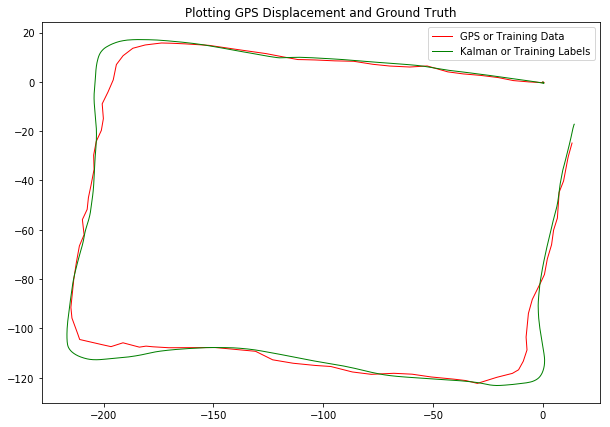

In [35]:
data = Data_Stream('data5.csv')
compute_kalman(data)
plt.figure(figsize=(10, 7))
ax=plt.subplot(111)
plt.plot(data.gps[:, 1], data.gps[:, 2], 'r-', lw=1, label='GPS or Training Data ') ##
plt.plot(data.kal_dis[:, 1], data.kal_dis[:, 2], 'g-', lw=1, label='Kalman or Training Labels') ##Training Labels
plt.title("Plotting GPS Displacement and Ground Truth") 
ax.legend()

### Get input data and correct labels in the right form

Parameter for choosing whether how much of data stream is training/test data

In [48]:
## Needed Data
gps = data.gps[:, 1:3]
acc = data.acc_ERC[:, 1:3]
vel = data.vel_ERC[:, 1:3]
mag = data.mag[:, 1:3]
gyro = data.gyro[:, 1:4]

time_series = data.acc_ERC[:, 0]
ground_truth = data.kal_dis[:, 1:3]
delta_time = np.diff(time_series, axis=0, prepend=0.0)


# Choose which data to include in input

just_acc = False
if (just_acc):
    input_data = np.concatenate((gps, acc, delta_time), axis=1)
else:
    input_data = np.concatenate((gps, acc, vel, mag, gyro, delta_time), axis=1)

x_dim = input_data.shape[1]
print("X Dim: ", x_dim)

## Split data for training and testing
num_train = int(0.70*input_data.shape[0])
num_test = input_data.shape[0] - num_train

training_data   = input_data[:num_train, :]
training_labels = ground_truth[:num_train, :]


test_data     = input_data[num_train:, :]
test_labels   = ground_truth[num_train:, :]

X Dim:  12


### Print Data with Pandas

In [49]:
if(just_acc):
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS X', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    training_frame = pd.DataFrame(np.concatenate((training_data, training_labels), axis=1), 
                                                 columns=['GPS X', 'GPS X', 'Acc X', 'Acc Y', 'Vel X', 'Vel Y', 
                                                          'Mag X', 'Mag Y',
                                                          'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Training Data")
print(training_frame.head(5))

Training Data
   GPS X  GPS X     Acc X     Acc Y     Vel X     Vel Y   Mag X  Mag Y  \
0    0.0    0.0  0.153295  0.062256  0.000000  0.000000  18.878   8.33   
1    0.0    0.0  0.153295  0.062256  0.153295  0.062256  18.878   8.33   
2    0.0    0.0  0.153295  0.062256  0.306591  0.124511  18.878   8.33   
3    0.0    0.0  0.153295  0.062256  0.459886  0.186767  18.878   8.33   
4    0.0    0.0  0.153295  0.062256  0.613181  0.249023  18.878   8.33   

     Gyro X    Gyro Y    Gyro Z  Delta Time  Ground Truth X  Ground_Truth Y  
0 -0.034000 -0.064000  0.169000     0.00000        0.000000        0.000000  
1 -0.019518 -0.078232  0.198463     0.02014        0.000031        0.000013  
2 -0.005014 -0.092486  0.227971     0.02017        0.000125        0.000051  
3  0.009518 -0.106768  0.257537     0.02021        0.000281        0.000114  
4  0.024000 -0.121000  0.287000     0.02014        0.000499        0.000203  


In [51]:
if(just_acc):
    training_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS X', 'Acc X', 'Acc Y', 
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
else:
    training_frame = pd.DataFrame(np.concatenate((test_data, test_labels), axis=1), 
                                                 columns=['GPS X', 'GPS X', 'Acc X', 'Acc Y', 'Vel X', 'Vel Y', 
                                                          'Mag X', 'Mag Y',
                                                          'Gyro X', 'Gyro Y', 'Gyro Z',
                                                          'Delta Time', 'Ground Truth X', 'Ground_Truth Y'])
print("Testing Data")
print(training_frame.head(5))

Testing Data
       GPS X       GPS X     Acc X     Acc Y       Vel X       Vel Y  \
0 -81.784360 -118.271747  0.771803 -0.061319 -146.110741  130.263199   
1 -81.619922 -118.290721  1.516855 -0.394356 -144.966412  130.035362   
2 -81.455077 -118.309742  0.673693  0.054729 -143.871138  129.865548   
3 -81.290476 -118.328734 -0.166063  0.509493 -143.617323  130.147659   
4 -81.125875 -118.347726 -1.003649  0.970600 -144.202179  130.887705   

       Mag X     Mag Y    Gyro X    Gyro Y    Gyro Z  Delta Time  \
0 -17.507044 -3.355261 -0.068999  0.086745 -0.041773     0.02020   
1 -17.323000 -3.365000 -0.292000  0.082000 -0.062000     0.02015   
2 -17.931603 -3.480448 -0.127837  0.075327 -0.011950     0.02020   
3 -18.539301 -3.595724  0.036081  0.068663  0.038025     0.02017   
4 -19.147000 -3.711000  0.200000  0.062000  0.088000     0.02017   

   Ground Truth X  Ground_Truth Y  
0      -79.216120     -117.603363  
1      -79.039527     -117.639570  
2      -78.862259     -117.675788  
3

### Create Scaling Object to Scale down data to between 0 and 1

In [52]:

x_scaler = MinMaxScaler()
scaled_training_data = x_scaler.fit_transform(training_data)
scaled_test_data = x_scaler.transform(test_data)

print("Min:", np.min(training_data))
print("Max:", np.max(training_data))
print("Min:", np.min(scaled_training_data))
print("Max:", np.max(scaled_training_data))

Min: -238.41074819602355
Max: 182.45285237232687
Min: 0.0
Max: 1.0000000000000002


In [7]:
y_scaler = MinMaxScaler()
scaled_training_labels = y_scaler.fit_transform(training_labels)
scaled_test_labels = y_scaler.transform(test_labels)
print("Min:", np.min(training_data))
print("Max:", np.max(training_data))
print("Min:", np.min(scaled_training_data))
print("Max:", np.max(scaled_training_data))

In [8]:
def batch_generator(batch_size, sequence_length):

    # Infinite loop.
    while True:
        # Allocate a new array for the batch of input-signals.
        x_shape = (batch_size, sequence_length, scaled_training_data.shape[1])
        x_batch = np.zeros(shape=x_shape, dtype=np.float16)

        # Allocate a new array for the batch of output-signals.
        y_shape = (batch_size, sequence_length, scaled_training_labels.shape[1])
        y_batch = np.zeros(shape=y_shape, dtype=np.float16)

        # Fill the batch with random sequences of data.
        for i in range(batch_size):
            # Get a random start-index.
            # This points somewhere into the training-data.
            idx = np.random.randint(num_train - sequence_length)
            
            # Copy the sequences of data starting at this index.
            x_batch[i] = scaled_training_data[idx:idx+sequence_length]
            y_batch[i] = scaled_training_labels[idx:idx+sequence_length]
        
        yield (x_batch, y_batch)

In [9]:
batch_size = 256
num_train

3141

In [10]:
generator = batch_generator(batch_size=batch_size,
                            sequence_length=50)
x_batch, y_batch = next(generator)

(256, 50, 5)
(256, 50, 2)


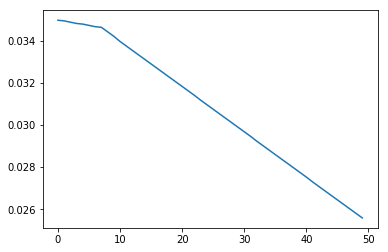

In [11]:
print(x_batch.shape)
print(y_batch.shape)
batch = 0   # First sequence in the batch.
signal = 0  # First signal from the 20 input-signals.
seq = x_batch[batch, :, signal]
plt.plot(seq)


In [12]:
validation_data = (np.expand_dims(scaled_test_data, axis=0),
                   np.expand_dims(scaled_test_labels, axis=0))

In [13]:
tf.keras.backend.clear_session()

model = Sequential()
model.add(GRU(units=512, return_sequences=True, input_shape=(None, scaled_training_data.shape[1],)))#
model.add(Dense(scaled_training_labels.shape[1], activation='sigmoid'))

In [14]:
warmup_steps = 50

In [15]:
def loss_mse_warmup(y_true, y_pred):
    # The shape of both input tensors are:
    # [batch_size, sequence_length, num_y_signals].

    # Ignore the "warmup" parts of the sequences
    # by taking slices of the tensors.
    y_true_slice = y_true[:, warmup_steps:, :]
    y_pred_slice = y_pred[:, warmup_steps:, :]

    # These sliced tensors both have this shape:
    # [batch_size, sequence_length - warmup_steps, num_y_signals]

    # Calculate the MSE loss for each value in these tensors.
    # This outputs a 3-rank tensor of the same shape.
    loss = tf.losses.mean_squared_error(labels=y_true_slice,
                                        predictions=y_pred_slice)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire tensor, we reduce it to a
    # single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [16]:
optimizer = RMSprop(lr=1e-3)
model.compile(loss=loss_mse_warmup, optimizer=optimizer)
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
gru (GRU)                    (None, None, 512)         795648    
_________________________________________________________________
dense (Dense)                (None, None, 2)           1026      
Total params: 796,674
Trainable params: 796,674
Non-trainable params: 0
_________________________________________________________________


In [17]:
path_checkpoint = '23_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      monitor='val_loss',
                                      verbose=1,
                                      save_weights_only=True,
                                      save_best_only=True)
callback_early_stopping = EarlyStopping(monitor='val_loss',
                                        patience=3, verbose=1)
callback_tensorboard = TensorBoard(log_dir='./23_logs/',
                                   histogram_freq=0,
                                   write_graph=False)
callback_reduce_lr = ReduceLROnPlateau(monitor='val_loss',
                                       factor=0.1,
                                       min_lr=1e-4,
                                       patience=0,
                                       verbose=1)
callbacks = [callback_early_stopping,
             callback_checkpoint,
             callback_tensorboard,
             callback_reduce_lr]

In [18]:
%%time
model.fit_generator(generator=generator,
                    epochs=20,
                    steps_per_epoch=100,
                    validation_data=validation_data,
                    callbacks=callbacks)

Epoch 1/20
1/1 [==============================] - 1s 596ms/sample - loss: 0.2043

Epoch 00001: val_loss improved from inf to 0.20428, saving model to 23_checkpoint.keras
100/100 [==============================] - 48s 483ms/step - loss: 0.0000e+00 - val_loss: 0.2043
Epoch 2/20
1/1 [==============================] - 1s 555ms/sample - loss: 0.2043

Epoch 00002: val_loss did not improve from 0.20428

Epoch 00002: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.
100/100 [==============================] - 48s 478ms/step - loss: 0.0000e+00 - val_loss: 0.2043
Epoch 3/20
1/1 [==============================] - 1s 556ms/sample - loss: 0.2043

Epoch 00003: val_loss did not improve from 0.20428

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.0001.
100/100 [==============================] - 48s 479ms/step - loss: 0.0000e+00 - val_loss: 0.2043
Epoch 4/20
1/1 [==============================] - 1s 557ms/sample - loss: 0.2043

Epoch 00004: val_loss did not improve from 0.2

In [19]:
result = model.evaluate(x=np.expand_dims(scaled_test_data, axis=0),
                        y=np.expand_dims(scaled_test_labels, axis=0))
print("loss (test-set):", result)

1/1 [==============================] - 1s 573ms/sample - loss: 0.2043
loss (test-set): 0.20428381860256195


In [20]:
def plot_comparison(start_idx, length=100, train=True):
    """
    Plot the predicted and true output-signals.
    
    :param start_idx: Start-index for the time-series.
    :param length: Sequence-length to process and plot.
    :param train: Boolean whether to use training- or test-set.
    """
    
    if train:
        # Use training-data.
        x = scaled_training_data
        y_true = training_labels
    else:
        # Use test-data.
        x = scaled_test_data
        y_true = test_labels
    
    # End-index for the sequences.
    end_idx = start_idx + length
    
    # Select the sequences from the given start-index and
    # of the given length.
    x = x[start_idx:end_idx]
    y_true = y_true[start_idx:end_idx]
    
    # Input-signals for the model.
    x = np.expand_dims(x, axis=0)

    # Use the model to predict the output-signals.
    y_pred = model.predict(x)
    
    # The output of the model is between 0 and 1.
    # Do an inverse map to get it back to the scale
    # of the original data-set.
    y_pred_rescaled = y_scaler.inverse_transform(y_pred[0])
    
    # For each output-signal.
    for signal in range(y_true.shape[1]):
        # Get the output-signal predicted by the model.
        signal_pred = y_pred_rescaled[:, signal]
        
        # Get the true output-signal from the data-set.
        signal_true = y_true[:, signal]

        # Make the plotting-canvas bigger.
        plt.figure(figsize=(15,5))
        
        # Plot and compare the two signals.
        plt.plot(signal_true, label='true')
        plt.plot(signal_pred, label='pred')
        
        # Plot grey box for warmup-period.
        p = plt.axvspan(0, warmup_steps, facecolor='black', alpha=0.15)
        
        # Plot labels etc.
        plt.ylabel(str(signal))
        plt.legend()
        plt.show()
        
    # Make the plotting-canvas bigger.
    plt.figure(figsize=(15,5))

    # Plot and compare the two signals.
    plt.plot(y_true[:, 0], y_true[:, 1], label='true')
    plt.plot(y_pred_rescaled[:, 0], y_pred_rescaled[:, 1], label='rescaled')

    plt.legend()
    plt.show()
        

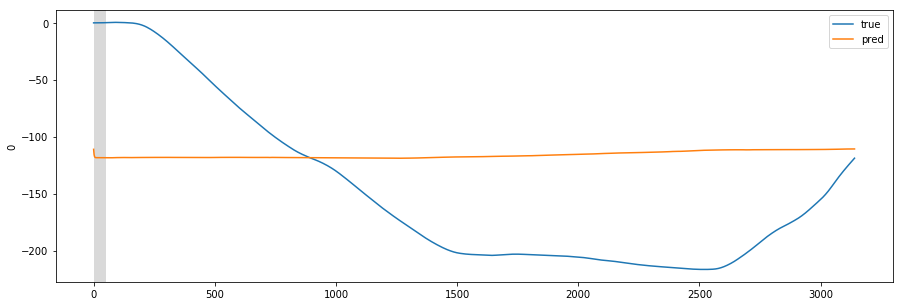

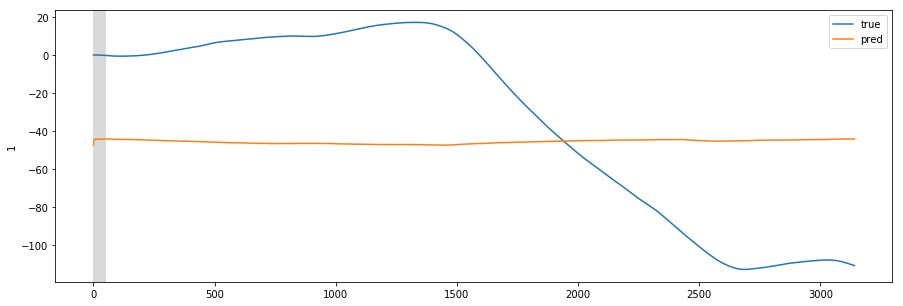

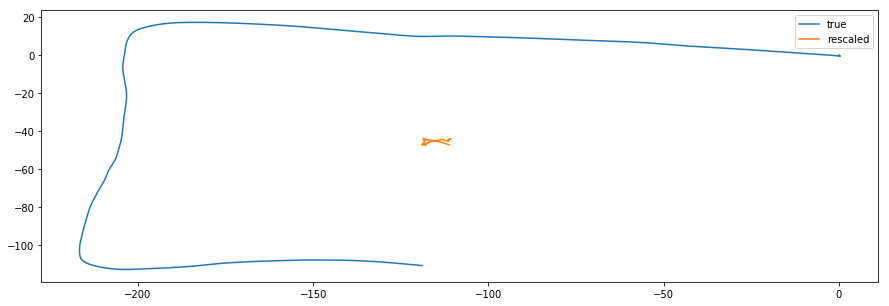

In [21]:
plot_comparison(start_idx=0, length=num_train, train=True)

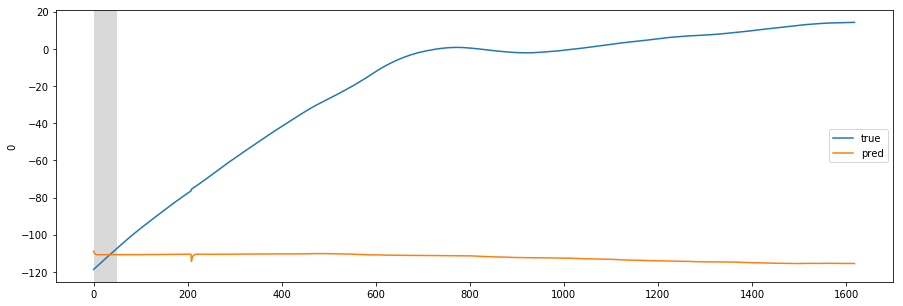

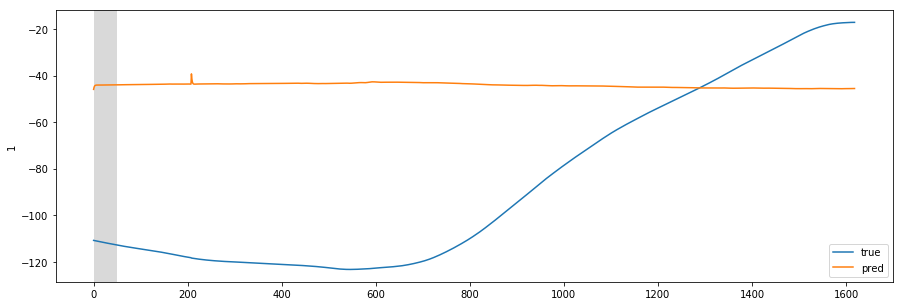

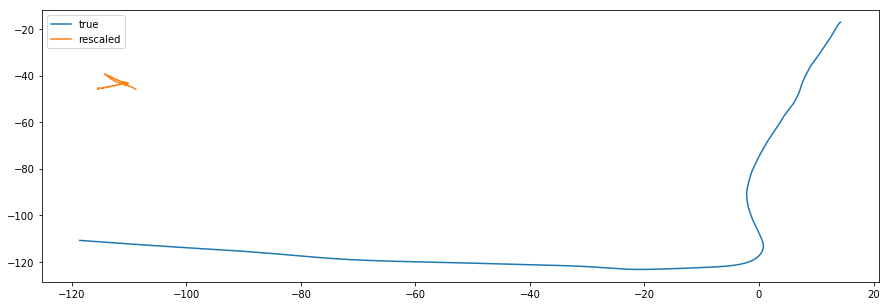

In [22]:
plot_comparison(start_idx=0, length=num_test, train=False)

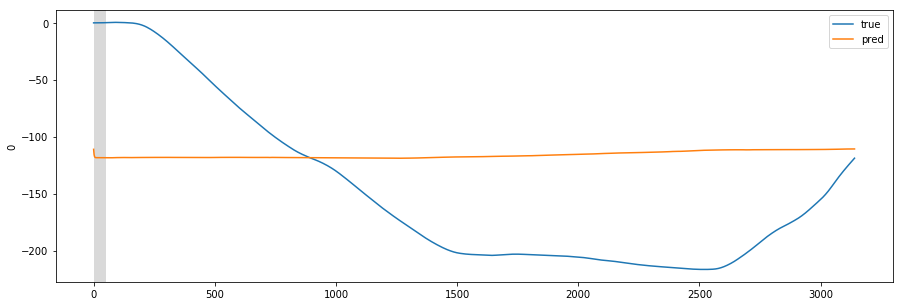

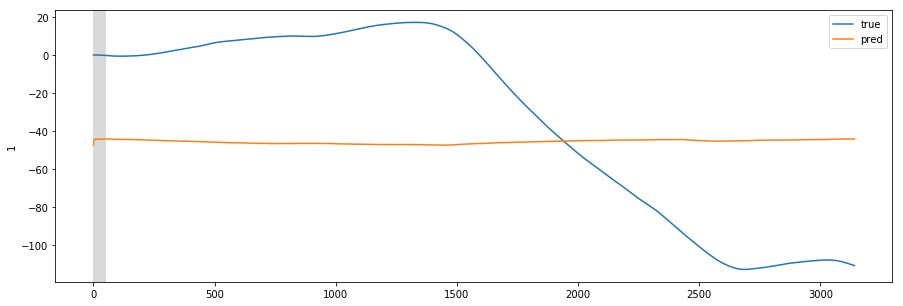

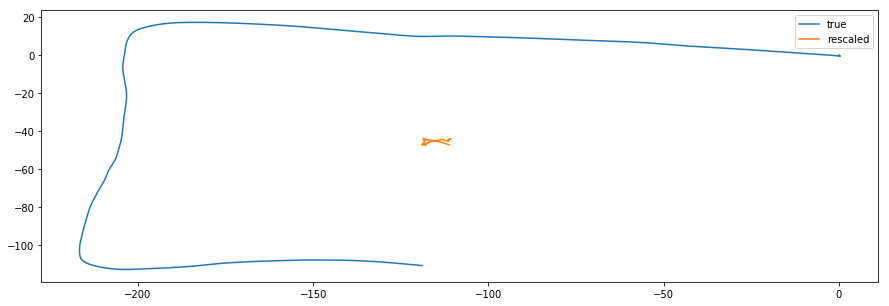

In [23]:
plot_comparison(start_idx=0, length=num_test+num_train, train=True)